In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Step 1: Load Your Labeled Data ---
print("Loading 'labeled_dataset.parquet'...")
df = pd.read_parquet('labeled_dataset.parquet')
print(f"DataFrame loaded with {len(df)} rows.")

# --- Step 2: Initialize the Graph ---
G = nx.DiGraph() # Use a Directed Graph
print("Initialized an empty Directed Graph.")

# --- Step 3: Add Nodes and Edges (Example) ---
# We'll iterate through a sample of the data first to build the graph quickly.
# Adjust the sample size as needed for your system's performance.
sample_size = 50000
print(f"Building graph from a sample of {sample_size} events...")
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

# Define columns to use for nodes
ip_col = 'sourceIPAddress'
arn_col = 'userIdentity.arn'
anomaly_col = 'anomaly_label'

# Iterate through the sample DataFrame rows
for index, row in df_sample.iterrows():
    ip = row[ip_col]
    arn = row[arn_col]
    anomaly = row[anomaly_col]
    event = row['event_name'] # Get the event name for the edge label

    # Add nodes if they don't exist, including the anomaly label for IPs
    if ip and not G.has_node(ip):
        G.add_node(ip, type='IP', anomaly=anomaly) # Add attributes
    if arn and not G.has_node(arn):
        G.add_node(arn, type='ARN') # Add attributes

    # Add a directed edge from IP to ARN, labeled by the event
    # Ensure both IP and ARN are valid before adding an edge
    if ip and arn:
        G.add_edge(ip, arn, event=event)

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --- Step 4: Basic Graph Info ---
print("\n--- Basic Graph Information ---")
# Count node types
node_types = pd.Series(nx.get_node_attributes(G, 'type')).value_counts()
print("Node Types:\n", node_types)

# Count anomalies among IP nodes
ip_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'IP']
anomaly_counts = pd.Series(nx.get_node_attributes(G, 'anomaly')).value_counts()
print("\nAnomaly Labels on IP Nodes:\n", anomaly_counts)





Loading 'labeled_dataset.parquet'...
DataFrame loaded with 1939207 rows.
Initialized an empty Directed Graph.
Building graph from a sample of 50000 events...
Graph built with 2166 nodes and 2529 edges.

--- Basic Graph Information ---
Node Types:
 IP     2149
ARN      17
Name: count, dtype: int64

Anomaly Labels on IP Nodes:
 Normal     2096
Anomaly      53
Name: count, dtype: int64



Attempting a simple visualization...
Visualization saved to simple_graph.png


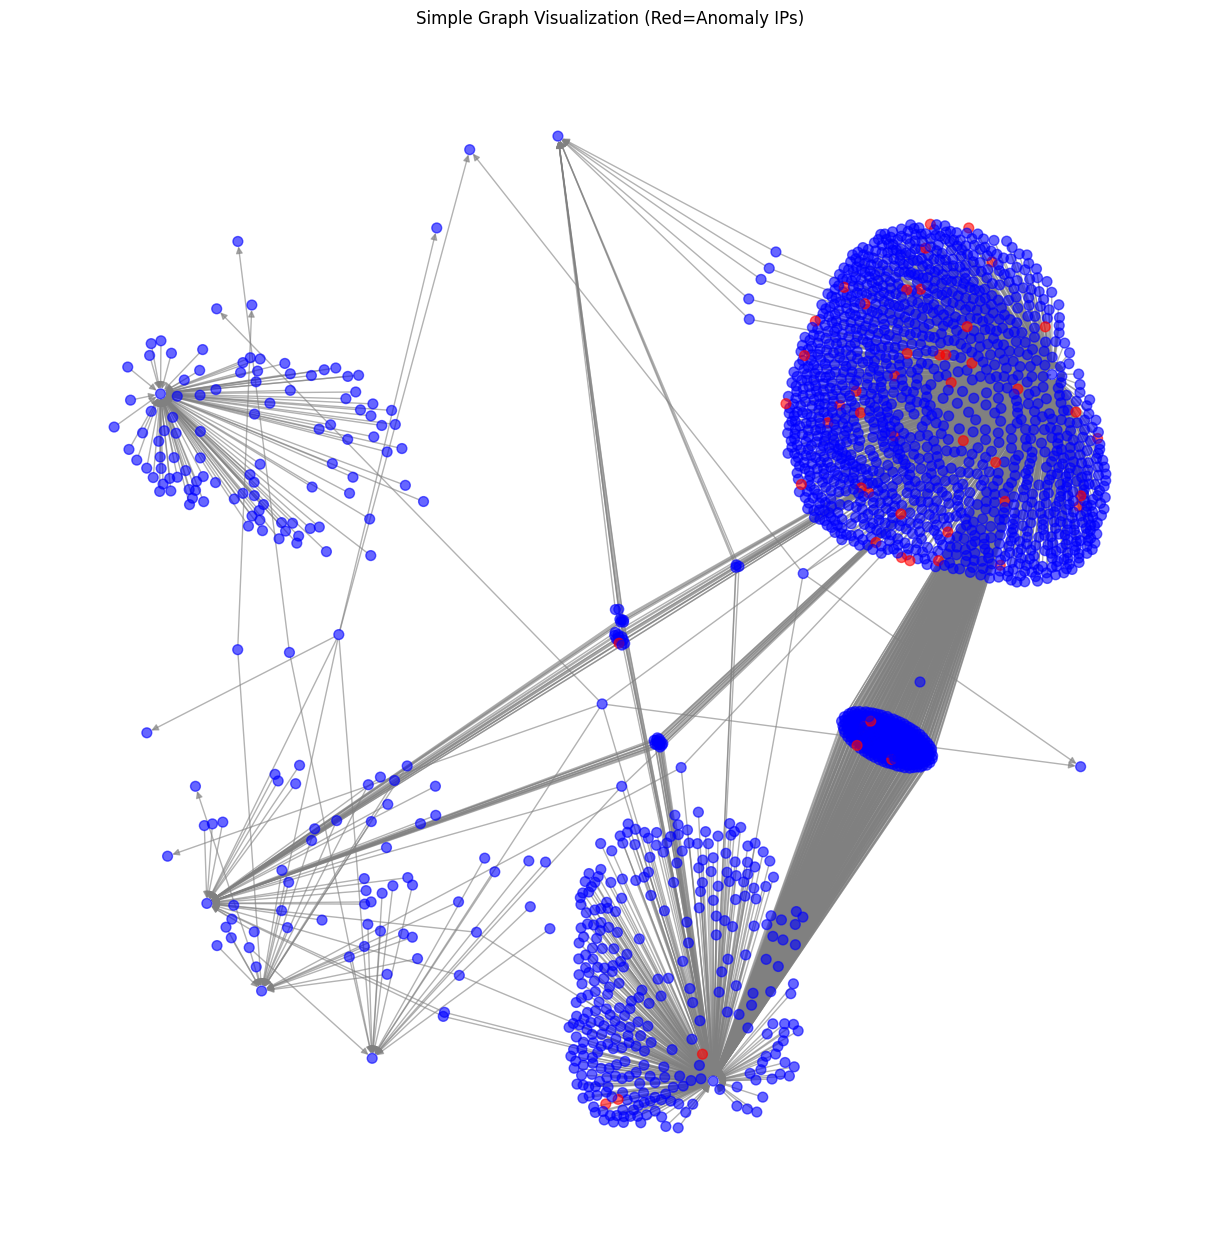

In [2]:
# --- Step 5: Simple Visualization (Optional - Can be slow for large graphs) ---
# This part might take time and memory. Start with a small sample if needed.
print("\nAttempting a simple visualization...")
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1) # Layout algorithm
node_colors = ['red' if G.nodes[n].get('anomaly') == 'Anomaly' else 'blue' for n in G.nodes()]
nx.draw(G, pos, node_size=50, node_color=node_colors, with_labels=False, alpha=0.6, edge_color='gray')
plt.title("Simple Graph Visualization (Red=Anomaly IPs)")
plt.savefig("simple_graph.png")
print("Visualization saved to simple_graph.png")

Confirmed 53 anomalous IP nodes in the graph.

--- Top 5 Most Central Nodes (by Out-Degree) ---
- Node: 255.253.125.115
  Type: IP
  Anomaly Status: Normal
  Out-Degree Centrality: 0.0028
  In-Degree Centrality: 0.0000
- Node: 250.251.253.3
  Type: IP
  Anomaly Status: Normal
  Out-Degree Centrality: 0.0028
  In-Degree Centrality: 0.0000
- Node: ec2-frontend-api.amazonaws.com
  Type: IP
  Anomaly Status: Normal
  Out-Degree Centrality: 0.0023
  In-Degree Centrality: 0.0000
- Node: 251.105.254.1
  Type: IP
  Anomaly Status: Normal
  Out-Degree Centrality: 0.0018
  In-Degree Centrality: 0.0000
- Node: 8.103.248.255
  Type: IP
  Anomaly Status: Normal
  Out-Degree Centrality: 0.0018
  In-Degree Centrality: 0.0000

Found 61 edges connected to anomalous nodes.

Generating visualization highlighting anomalies...
Visualization saved to anomaly_graph_visualization.png


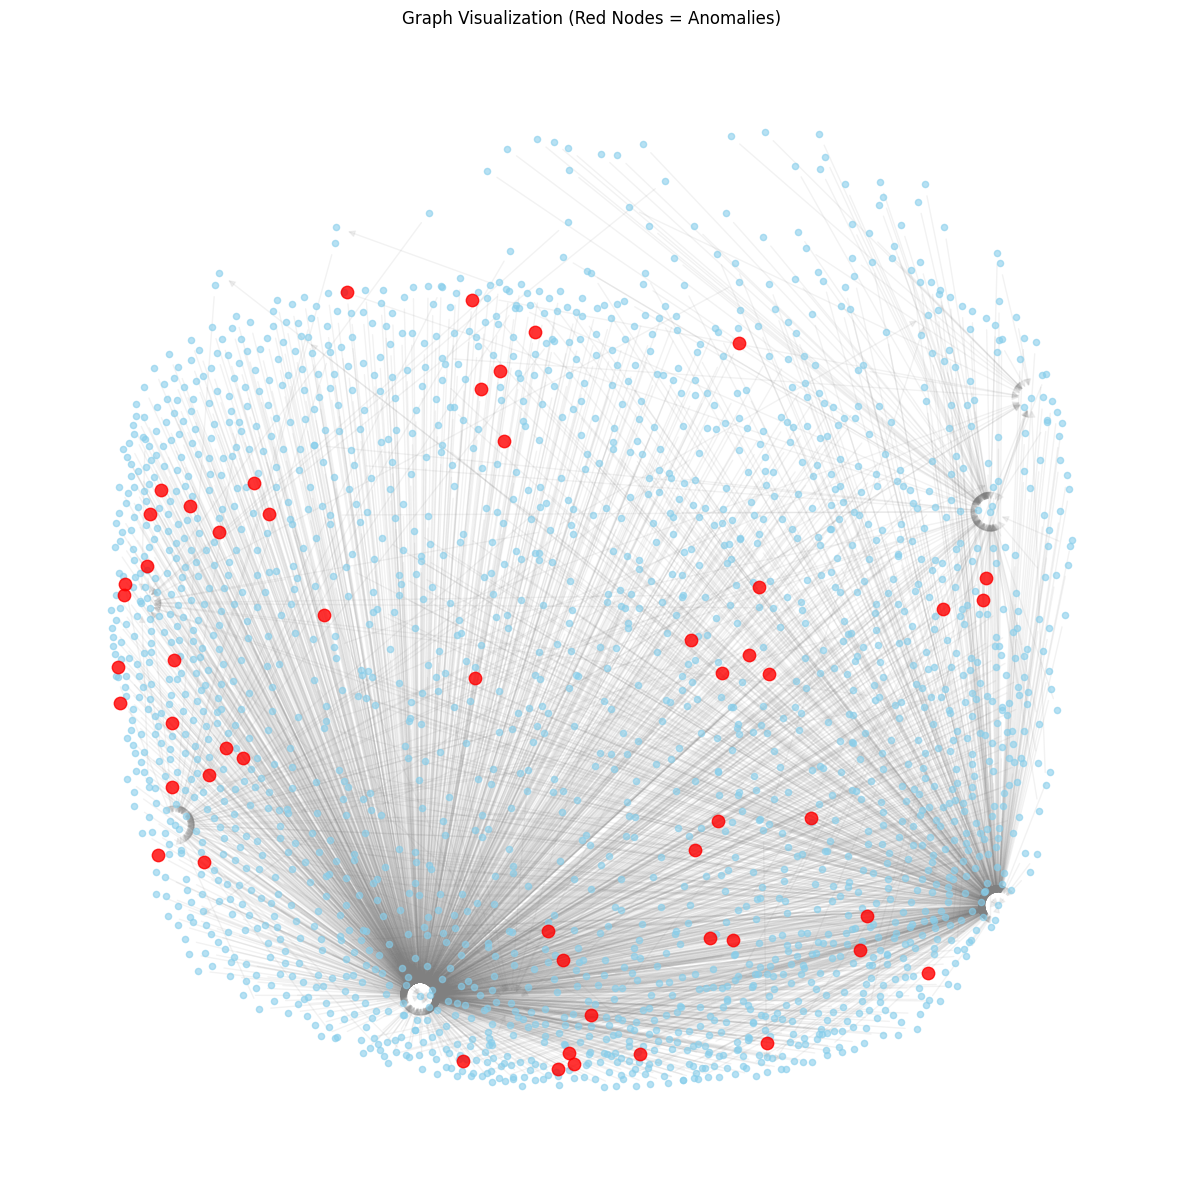

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume 'G' is your graph object already loaded in memory from the previous step.
# If not, you'd need to re-run the code that builds G first.

# --- Step 1: Identify Anomalous Nodes ---
anomaly_nodes = [n for n, d in G.nodes(data=True) if d.get('anomaly') == 'Anomaly']
normal_nodes = [n for n, d in G.nodes(data=True) if n not in anomaly_nodes]
print(f"Confirmed {len(anomaly_nodes)} anomalous IP nodes in the graph.")

# --- Step 2: Calculate Degree Centrality ---
# Degree centrality measures how many connections a node has.
out_degree_centrality = nx.out_degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)

# Find the top 5 most central nodes (most outgoing connections)
top_5_central_nodes = sorted(out_degree_centrality, key=out_degree_centrality.get, reverse=True)[:5]

print("\n--- Top 5 Most Central Nodes (by Out-Degree) ---")
for node in top_5_central_nodes:
    anomaly_status = G.nodes[node].get('anomaly', 'N/A (Not IP)') # Check if it's an anomaly
    print(f"- Node: {node}")
    print(f"  Type: {G.nodes[node].get('type', 'Unknown')}")
    print(f"  Anomaly Status: {anomaly_status}")
    print(f"  Out-Degree Centrality: {out_degree_centrality[node]:.4f}") # Activity originating FROM this node
    print(f"  In-Degree Centrality: {in_degree_centrality.get(node, 0):.4f}") # Activity pointing TO this node

# --- Step 3: Prepare for Visualization ---
# Find edges connected to anomalous nodes
anomaly_edges = []
for u, v in G.edges():
    if u in anomaly_nodes or v in anomaly_nodes:
        anomaly_edges.append((u, v))

print(f"\nFound {len(anomaly_edges)} edges connected to anomalous nodes.")

# --- Step 4: Visualize Highlighting Anomalies ---
print("\nGenerating visualization highlighting anomalies...")
plt.figure(figsize=(15, 15))

# Position nodes using a layout algorithm
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Draw normal nodes (smaller, blue)
nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_size=20, node_color='skyblue', alpha=0.6)

# Draw anomalous nodes (larger, red)
nx.draw_networkx_nodes(G, pos, nodelist=anomaly_nodes, node_size=80, node_color='red', alpha=0.8)

# Draw all edges lightly
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# Optional: Draw edges connected to anomalies more prominently (can be messy)
# nx.draw_networkx_edges(G, pos, edgelist=anomaly_edges, alpha=0.5, edge_color='orange', width=1.5)

# Optional: Add labels only to anomalous nodes
# labels = {n:n for n in anomaly_nodes}
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Graph Visualization (Red Nodes = Anomalies)")
plt.axis('off')
plt.savefig("anomaly_graph_visualization.png")
print("Visualization saved to anomaly_graph_visualization.png")

In [4]:
import pandas as pd
import networkx as nx

# Assume 'G' is your graph object already loaded in memory.
# Assume 'anomaly_nodes' list is also available.
# If not, re-run the previous cells to create G and anomaly_nodes.

print(f"Analyzing neighbors for the {len(anomaly_nodes)} anomalous nodes...")

# Limit the output to the first few anomalies for brevity
num_anomalies_to_show = 5
count = 0

for node in anomaly_nodes:
    if count >= num_anomalies_to_show:
        break

    print(f"\n--- Interactions for Anomalous IP: {node} ---")

    # Find nodes this IP sent events TO (Successors)
    successors = list(G.successors(node))
    if successors:
        print("  Actions initiated BY this IP:")
        for successor in successors:
            # Get edge data (which includes the event name)
            edge_data = G.get_edge_data(node, successor)
            event = edge_data.get('event', 'Unknown Event')
            successor_type = G.nodes[successor].get('type', 'Unknown')
            print(f"    - Event: '{event}' --> Target: {successor} (Type: {successor_type})")

    # Find nodes that sent events TO this IP (Predecessors) - Less common for IP nodes
    predecessors = list(G.predecessors(node))
    if predecessors:
        print("  Actions targeting THIS IP:")
        for predecessor in predecessors:
            edge_data = G.get_edge_data(predecessor, node)
            event = edge_data.get('event', 'Unknown Event')
            predecessor_type = G.nodes[predecessor].get('type', 'Unknown')
            print(f"    - Event: '{event}' <-- Source: {predecessor} (Type: {predecessor_type})")

    if not successors and not predecessors:
        print("  - No direct interactions found in the graph sample for this node.")

    count += 1

if len(anomaly_nodes) > num_anomalies_to_show:
    print(f"\n... Analysis shown for the first {num_anomalies_to_show} anomalous nodes.")

Analyzing neighbors for the 53 anomalous nodes...

--- Interactions for Anomalous IP: 237.87.246.92 ---
  Actions initiated BY this IP:
    - Event: 'GetBucketAcl' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)
    - Event: 'ListSubscriptions' --> Target: arn:aws:iam::811596193553:user/Level6 (Type: ARN)

--- Interactions for Anomalous IP: 236.9.245.88 ---
  Actions initiated BY this IP:
    - Event: 'GetBucketAcl' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 84.252.252.117 ---
  Actions initiated BY this IP:
    - Event: 'GetBucketPolicy' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 5.1.242.5 ---
  Actions initiated BY this IP:
    - Event: 'AssumeRole' --> Target: arn:aws:iam::811596193553:user/Level6 (Type: ARN)
    - Event: 'DescribeSnapshots' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 193.8.125.1 ---
  Actio

In [5]:
import pandas as pd # Still used for Series/value_counts at the end
import networkx as nx
import pyarrow as pa
import pyarrow.parquet as pq

# --- Configuration ---
parquet_file = 'labeled_dataset.parquet'
# Columns to use
ip_col = 'sourceIPAddress'
arn_col = 'userIdentity.arn'
anomaly_col = 'anomaly_label'
event_col = 'event_name' # Make sure this exists

# --- Initialize Graph ---
G_full = nx.DiGraph()
print("Initialized an empty Directed Graph for the full dataset.")

# --- Process Parquet File Incrementally using PyArrow ONLY ---
print(f"Reading '{parquet_file}' incrementally by row group using PyArrow...")

parquet_reader = pq.ParquetFile(parquet_file)
num_row_groups = parquet_reader.num_row_groups
total_rows = 0

# Iterate through each row group
for i in range(num_row_groups):
    print(f"  - Processing row group {i+1}/{num_row_groups}...")
    # Read row group directly as a PyArrow Table
    table = parquet_reader.read_row_group(i)
    total_rows += table.num_rows

    # --- Build graph directly from PyArrow Table (NO PANDAS DF) ---

    # Extract required columns as PyArrow Arrays (memory efficient)
    try:
        ip_array = table.column(ip_col)
    except KeyError:
        print(f"    Warning: Column '{ip_col}' not found in row group {i+1}. Skipping IP nodes/edges for this group.")
        continue # Skip to next row group if essential IP column missing

    # Handle potentially missing optional columns
    arn_array = table.column(arn_col) if arn_col in table.column_names else None
    anomaly_array = table.column(anomaly_col) if anomaly_col in table.column_names else None
    event_array = table.column(event_col) if event_col in table.column_names else None

    # Get python lists - conversion might still use memory, but less than full DF
    # Process in smaller batches within the row group if needed, but try direct conversion first
    ips = ip_array.to_pylist()
    arns = arn_array.to_pylist() if arn_array else [None] * table.num_rows
    anomalies = anomaly_array.to_pylist() if anomaly_array else ['Normal'] * table.num_rows
    events = event_array.to_pylist() if event_array else ['Unknown Event'] * table.num_rows

    # Iterate through the extracted lists (more efficient than iterrows)
    for idx in range(table.num_rows):
        ip = ips[idx]
        arn = arns[idx]
        anomaly = anomalies[idx] if anomalies[idx] is not None else 'Normal' # Handle potential None
        event = events[idx] if events[idx] is not None else 'Unknown Event' # Handle potential None

        # Add/Update IP nodes
        if ip is not None: # Check if ip is valid
             # Convert PyArrow scalar to Python string if necessary
             ip_str = str(ip)
             if not G_full.has_node(ip_str):
                 G_full.add_node(ip_str, type='IP', anomaly=str(anomaly))
             # Update anomaly status if needed
             elif G_full.nodes[ip_str].get('anomaly') != str(anomaly):
                 G_full.nodes[ip_str]['anomaly'] = str(anomaly)

        # Add ARN nodes
        if arn is not None: # Check if arn is valid
            arn_str = str(arn)
            if not G_full.has_node(arn_str):
                G_full.add_node(arn_str, type='ARN')

        # Add Edges
        if ip is not None and arn is not None:
            ip_str = str(ip)
            arn_str = str(arn)
            # Ensure edge doesn't already exist before adding attributes, or update existing
            if G_full.has_edge(ip_str, arn_str):
                 # Optionally update edge attributes if multiple events occur
                 # G_full.edges[ip_str, arn_str]['event'] += f",{str(event)}" # Example: append event
                 pass # Or simply skip if edge exists
            else:
                 G_full.add_edge(ip_str, arn_str, event=str(event))


print(f"\nFinished processing {total_rows} rows from {num_row_groups} row groups.")
# Check graph size AFTER the loop finishes
print(f"Full graph built with {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges.")


# --- Basic Graph Info ---
print("\n--- Full Graph Information ---")
# Need to handle potential non-string node names if conversion failed
node_types = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_full, 'type').items()}).value_counts()
print("Node Types:\n", node_types)

anomaly_counts = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_full, 'anomaly').items()}).value_counts()
print("\nAnomaly Labels on IP Nodes:\n", anomaly_counts)

Initialized an empty Directed Graph for the full dataset.
Reading 'labeled_dataset.parquet' incrementally by row group using PyArrow...
  - Processing row group 1/2...
  - Processing row group 2/2...

Finished processing 1939207 rows from 2 row groups.
Full graph built with 9460 nodes and 11624 edges.

--- Full Graph Information ---
Node Types:
 IP     9402
ARN      58
Name: count, dtype: int64

Anomaly Labels on IP Nodes:
 Normal     9282
Anomaly     120
Name: count, dtype: int64


In [6]:
import pandas as pd
import networkx as nx

# Assume 'G_full' is your full graph object already loaded in memory.
# If not, you need to reload it or recreate it first.

# --- Step 1: Identify Anomalous Nodes ---
# Ensure anomaly nodes are identified correctly (as strings, matching graph nodes)
anomaly_nodes = [str(n) for n, d in G_full.nodes(data=True) if d.get('anomaly') == 'Anomaly']
print(f"Analyzing neighbors for the {len(anomaly_nodes)} anomalous nodes...")

# --- Step 2: Analyze Neighbors and Actions ---
num_anomalies_to_show = 10 # Show details for the first 10 anomalies found
count = 0

for node in anomaly_nodes:
    if count >= num_anomalies_to_show:
        break

    print(f"\n--- Interactions for Anomalous IP: {node} ---")

    # Find nodes this IP sent events TO (Successors)
    try:
        successors = list(G_full.successors(node))
        if successors:
            print("  Actions initiated BY this IP:")
            for successor in successors:
                # Get edge data (which includes the event name)
                # NetworkX might store multiple edges between nodes if added repeatedly;
                # get_edge_data gets data for one such edge.
                edge_data = G_full.get_edge_data(node, successor)
                # In case of multiple edges, edge_data might be a dict of dicts if keys were used
                # We'll assume the simple case first where edge_data is the attribute dict
                event = edge_data.get('event', 'Unknown Event') if edge_data else 'Unknown Event (edge data missing)'
                
                # Check successor type safely
                successor_type = G_full.nodes.get(successor, {}).get('type', 'Unknown')
                print(f"    - Event: '{event}' --> Target: {successor} (Type: {successor_type})")
    except Exception as e:
        print(f"    Error getting successors for {node}: {e}")


    # Find nodes that sent events TO this IP (Predecessors)
    try:
        predecessors = list(G_full.predecessors(node))
        if predecessors:
            print("  Actions targeting THIS IP:")
            for predecessor in predecessors:
                edge_data = G_full.get_edge_data(predecessor, node)
                event = edge_data.get('event', 'Unknown Event') if edge_data else 'Unknown Event (edge data missing)'
                
                # Check predecessor type safely
                predecessor_type = G_full.nodes.get(predecessor, {}).get('type', 'Unknown')
                print(f"    - Event: '{event}' <-- Source: {predecessor} (Type: {predecessor_type})")
    except Exception as e:
         print(f"    Error getting predecessors for {node}: {e}")


    # Check if any interactions were found via either method
    try:
        if not successors and not predecessors:
             print("  - No direct interactions found in the graph for this node.")
    except NameError: # Handle case where successors/predecessors list creation failed
         print("  - Could not determine interactions due to error.")


    count += 1

if len(anomaly_nodes) > num_anomalies_to_show:
    print(f"\n... Analysis shown for the first {num_anomalies_to_show} anomalous nodes.")

Analyzing neighbors for the 120 anomalous nodes...

--- Interactions for Anomalous IP: 6.255.9.149 ---
  Actions initiated BY this IP:
    - Event: 'DescribeVolumes' --> Target: arn:aws:iam::811596193553:root (Type: ARN)

--- Interactions for Anomalous IP: 47.174.143.250 ---
  Actions initiated BY this IP:
    - Event: 'ListBuckets' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 69.35.210.232 ---
  Actions initiated BY this IP:
    - Event: 'ListBuckets' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 251.126.38.233 ---
  Actions initiated BY this IP:
    - Event: 'ListBuckets' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 223.137.239.205 ---
  Actions initiated BY this IP:
    - Event: 'ListBuckets' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)

--- Interactions for Anomalous IP: 213.253.166.5 ---
  Actions initiated B

In [7]:
import pandas as pd
import networkx as nx
import time # To time the centrality calculation

# Assume 'G_full' is your full graph object already loaded in memory.
# Assume 'anomaly_nodes' list (containing strings of anomalous IPs) is also available.
# If not, you need to reload G_full and identify anomaly_nodes first.

print(f"Starting centrality analysis for the full graph ({G_full.number_of_nodes()} nodes, {G_full.number_of_edges()} edges)...")

# --- Step 1: Calculate Degree Centrality ---
print("Calculating Degree Centrality...")
start_time = time.time()
# Calculate both in-degree and out-degree separately
in_degree_centrality = nx.in_degree_centrality(G_full)
out_degree_centrality = nx.out_degree_centrality(G_full)
# Combine them for total degree (or just focus on out-degree for originating activity)
degree_centrality = {node: in_degree_centrality.get(node, 0) + out_degree_centrality.get(node, 0) for node in G_full.nodes()}
print(f"  Degree Centrality calculated in {time.time() - start_time:.2f} seconds.")

# --- Step 2: Calculate Betweenness Centrality ---
# WARNING: This can be very slow on large graphs.
print("Calculating Betweenness Centrality (this might take a while)...")
start_time = time.time()
try:
    # Consider using a smaller 'k' for approximation on large graphs if needed
    # k = min(1000, G_full.number_of_nodes() // 10) # Example: sample k nodes
    # betweenness_centrality = nx.betweenness_centrality(G_full, k=k, normalized=True)
    betweenness_centrality = nx.betweenness_centrality(G_full, normalized=True)
    print(f"  Betweenness Centrality calculated in {time.time() - start_time:.2f} seconds.")
    betweenness_available = True
except Exception as e:
    print(f"  Could not calculate Betweenness Centrality: {e}. Skipping.")
    betweenness_centrality = {} # Empty dict if calculation fails
    betweenness_available = False


# --- Step 3: Analyze Centrality for Anomalous Nodes ---
print("\n--- Centrality Analysis for Anomalous Nodes ---")
anomaly_centrality_data = []

for node in anomaly_nodes:
    data = {
        'Node': node,
        'Degree': degree_centrality.get(node, 0),
        'Out_Degree': out_degree_centrality.get(node, 0), # How many nodes it connects TO
        'In_Degree': in_degree_centrality.get(node, 0),   # How many nodes connect TO it
    }
    if betweenness_available:
        data['Betweenness'] = betweenness_centrality.get(node, 0)
    anomaly_centrality_data.append(data)

# Create a DataFrame for easier sorting and viewing
df_anomaly_centrality = pd.DataFrame(anomaly_centrality_data)

# --- Step 4: Show Top Anomalous Nodes by Centrality ---

print("\n--- Top 5 Anomalous Nodes by Total Degree ---")
print(df_anomaly_centrality.sort_values(by='Degree', ascending=False).head(5))

print("\n--- Top 5 Anomalous Nodes by Out-Degree ---")
print(df_anomaly_centrality.sort_values(by='Out_Degree', ascending=False).head(5))

if betweenness_available:
    print("\n--- Top 5 Anomalous Nodes by Betweenness Centrality ---")
    print(df_anomaly_centrality.sort_values(by='Betweenness', ascending=False).head(5))

# --- Step 5: Path Finding (Example between top 2 degree anomalies) ---
# Note: Path finding in large graphs can also be slow. Let's find one example path.
print("\n--- Path Finding Example ---")
if len(df_anomaly_centrality) >= 2:
    top_degree_nodes = df_anomaly_centrality.sort_values(by='Degree', ascending=False)['Node'].tolist()
    source_node = top_degree_nodes[0]
    target_node = top_degree_nodes[1] # Example: path between top 2

    print(f"Searching for shortest path between top degree anomalies: {source_node} -> {target_node}")
    try:
        path = nx.shortest_path(G_full, source=source_node, target=target_node)
        print(f"  Shortest path found: {' -> '.join(path)}")
        # You could then analyze the events along this path
        for i in range(len(path) - 1):
            edge_data = G_full.get_edge_data(path[i], path[i+1])
            event = edge_data.get('event', 'Unknown') if edge_data else 'Unknown'
            print(f"    Step: {path[i]} --({event})--> {path[i+1]}")

    except nx.NetworkXNoPath:
        print(f"  No path found between {source_node} and {target_node}.")
    except Exception as e:
        print(f"  Error finding path: {e}")
else:
    print("  Not enough anomalous nodes to find a path between the top 2.")

Starting centrality analysis for the full graph (9460 nodes, 11624 edges)...
Calculating Degree Centrality...
  Degree Centrality calculated in 0.07 seconds.
Calculating Betweenness Centrality (this might take a while)...
  Betweenness Centrality calculated in 362.29 seconds.

--- Centrality Analysis for Anomalous Nodes ---

--- Top 5 Anomalous Nodes by Total Degree ---
              Node    Degree  Out_Degree  In_Degree  Betweenness
66     42.157.9.48  0.000423    0.000423        0.0          0.0
8      97.84.219.1  0.000317    0.000317        0.0          0.0
69      249.19.8.3  0.000317    0.000317        0.0          0.0
42   253.182.6.139  0.000317    0.000317        0.0          0.0
104  253.3.251.245  0.000317    0.000317        0.0          0.0

--- Top 5 Anomalous Nodes by Out-Degree ---
              Node    Degree  Out_Degree  In_Degree  Betweenness
66     42.157.9.48  0.000423    0.000423        0.0          0.0
8      97.84.219.1  0.000317    0.000317        0.0          0

Found 4 direct neighbors for 42.157.9.48.
Subgraph created with 5 nodes and 4 edges.
Subgraph visualization saved to neighborhood_42.157.9.48.png


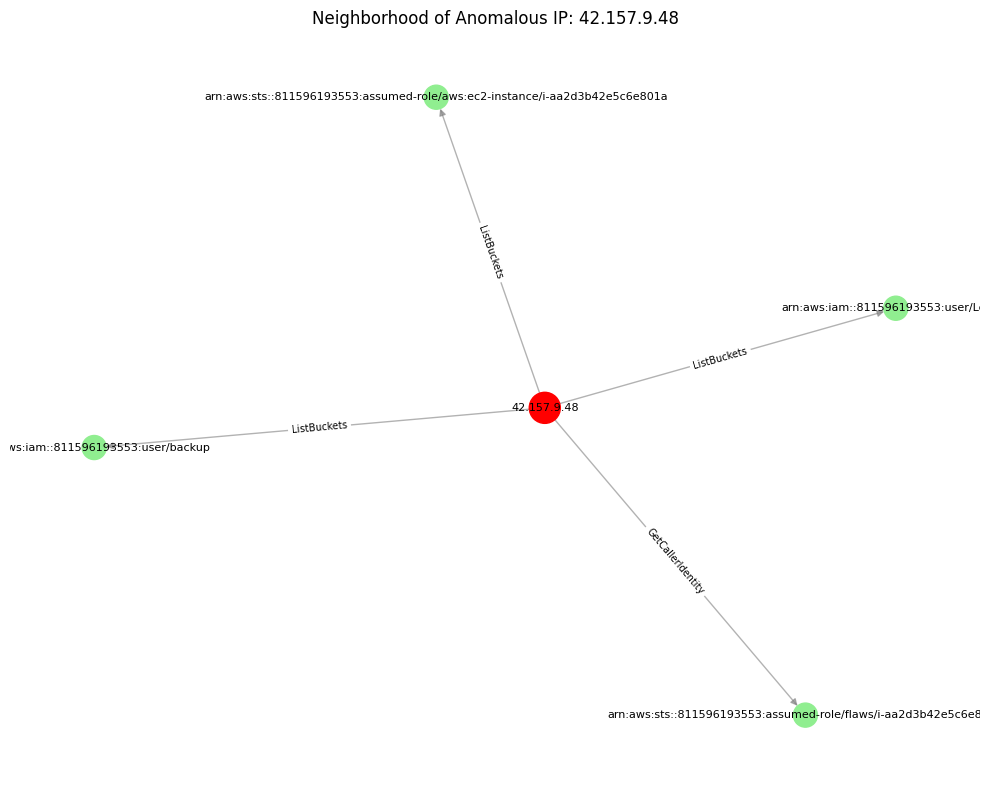

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume 'G_full' is your full graph object already loaded in memory.
# Assume 'anomaly_nodes' list is also available.

# --- Step 1: Define the Target Node ---
target_node = '42.157.9.48' # The most active anomaly

if target_node not in G_full:
    print(f"Error: Target node {target_node} not found in the graph.")
else:
    # --- Step 2: Get Neighbors ---
    # Find all nodes directly connected to the target node (successors and predecessors)
    neighbors = list(nx.neighbors(G_full, target_node)) # Gets both in and out neighbors
    nodes_in_subgraph = [target_node] + neighbors
    print(f"Found {len(neighbors)} direct neighbors for {target_node}.")

    # --- Step 3: Create the Subgraph ---
    subgraph = G_full.subgraph(nodes_in_subgraph)
    print(f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

    # --- Step 4: Visualize the Subgraph ---
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph, seed=42) # Use a seed for consistent layout

    # Define node colors and sizes
    node_colors = []
    node_sizes = []
    for node in subgraph.nodes():
        if node == target_node:
            node_colors.append('red') # Highlight the central anomaly
            node_sizes.append(500)
        elif G_full.nodes[node].get('type') == 'ARN':
            node_colors.append('lightgreen') # Color for ARNs
            node_sizes.append(300)
        else: # Other IPs in the neighborhood
            node_colors.append('skyblue')
            node_sizes.append(200)

    # Draw the graph components
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.6, arrows=True)
    nx.draw_networkx_labels(subgraph, pos, font_size=8) # Label all nodes in the small graph

    # Add edge labels (event names)
    edge_labels = nx.get_edge_attributes(subgraph, 'event')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Neighborhood of Anomalous IP: {target_node}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"neighborhood_{target_node}.png")
    print(f"Subgraph visualization saved to neighborhood_{target_node}.png")

In [9]:
import pandas as pd
import networkx as nx
import pyarrow.parquet as pq
import datetime # To handle timestamps

# --- Configuration ---
parquet_file = 'labeled_dataset.parquet'
# Columns to use
ip_col = 'sourceIPAddress'
arn_col = 'userIdentity.arn'
anomaly_col = 'anomaly_label'
event_col = 'event_name' # Make sure this exists
time_col = 'eventTime'   # The timestamp column

# --- Initialize Graph ---
G_temporal = nx.DiGraph()
print("Initialized an empty Directed Graph for the temporal analysis.")

# --- Process Parquet File Incrementally using PyArrow ---
print(f"Reading '{parquet_file}' incrementally to build temporal graph...")

parquet_reader = pq.ParquetFile(parquet_file)
num_row_groups = parquet_reader.num_row_groups
total_rows = 0

# Iterate through each row group
for i in range(num_row_groups):
    print(f"  - Processing row group {i+1}/{num_row_groups}...")
    table = parquet_reader.read_row_group(i)
    total_rows += table.num_rows

    # Extract required columns as PyArrow Arrays (memory efficient)
    try:
        ip_array = table.column(ip_col)
        # Convert timestamps directly using PyArrow for efficiency if possible
        # Assuming eventTime was saved as a string that needs parsing,
        # or potentially already as a timestamp type in Parquet.
        # If it's already a timestamp type, to_pylist() might yield datetime objects.
        time_array = table.column(time_col)
    except KeyError as e:
        print(f"    Warning: Essential column '{e}' not found in row group {i+1}. Skipping group.")
        continue

    # Handle potentially missing optional columns
    arn_array = table.column(arn_col) if arn_col in table.column_names else None
    anomaly_array = table.column(anomaly_col) if anomaly_col in table.column_names else None
    event_array = table.column(event_col) if event_col in table.column_names else None

    # Get python lists
    ips = ip_array.to_pylist()
    times_raw = time_array.to_pylist() # Raw timestamps (might be strings or datetime objects)
    arns = arn_array.to_pylist() if arn_array else [None] * table.num_rows
    anomalies = anomaly_array.to_pylist() if anomaly_array else ['Normal'] * table.num_rows
    events = event_array.to_pylist() if event_array else ['Unknown Event'] * table.num_rows

    # Iterate through the extracted lists
    for idx in range(table.num_rows):
        ip = ips[idx]
        arn = arns[idx]
        anomaly = anomalies[idx] if anomalies[idx] is not None else 'Normal'
        event = events[idx] if events[idx] is not None else 'Unknown Event'
        timestamp_raw = times_raw[idx]

        # Convert timestamp string to datetime object if necessary
        try:
             # Attempt conversion assuming ISO format like '2017-02-12T19:57:06Z'
             # Check if it's already a datetime object (from Parquet read)
             if isinstance(timestamp_raw, datetime.datetime):
                 timestamp = timestamp_raw
             else:
                 # Clean potential timezone info if present as string (e.g., 'Z' for UTC)
                 timestamp_str = str(timestamp_raw).replace('Z', '+00:00')
                 timestamp = pd.to_datetime(timestamp_str, errors='coerce') # Coerce errors to NaT

             if pd.isna(timestamp): continue # Skip if timestamp is invalid

        except Exception as e:
            # print(f"    Warning: Could not parse timestamp '{timestamp_raw}'. Skipping edge time attribute. Error: {e}")
            timestamp = None # Assign None if parsing fails

        # Add/Update IP nodes
        if ip is not None:
             ip_str = str(ip)
             if not G_temporal.has_node(ip_str):
                 G_temporal.add_node(ip_str, type='IP', anomaly=str(anomaly))
             elif G_temporal.nodes[ip_str].get('anomaly') != str(anomaly):
                 G_temporal.nodes[ip_str]['anomaly'] = str(anomaly)

        # Add ARN nodes
        if arn is not None:
            arn_str = str(arn)
            if not G_temporal.has_node(arn_str):
                G_temporal.add_node(arn_str, type='ARN')

        # Add Edges with timestamp
        if ip is not None and arn is not None and timestamp is not None:
            ip_str = str(ip)
            arn_str = str(arn)
            # Add edge with event name AND timestamp
            # Note: NetworkX overwrites edge attributes if edge exists.
            # If multiple events happen between same IP/ARN, only last timestamp/event might be kept.
            # For full history, consider MultiDiGraph or different node structure.
            G_temporal.add_edge(ip_str, arn_str, event=str(event), timestamp=timestamp)


print(f"\nFinished processing {total_rows} rows from {num_row_groups} row groups.")
print(f"Temporal graph built with {G_temporal.number_of_nodes()} nodes and {G_temporal.number_of_edges()} edges.")

# --- Basic Graph Info ---
print("\n--- Temporal Graph Information ---")
node_types = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_temporal, 'type').items()}).value_counts()
print("Node Types:\n", node_types)

anomaly_counts = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_temporal, 'anomaly').items()}).value_counts()
print("\nAnomaly Labels on IP Nodes:\n", anomaly_counts)

# Example: Get timestamp of one edge
if G_temporal.number_of_edges() > 0:
    first_edge = list(G_temporal.edges(data=True))[0]

Initialized an empty Directed Graph for the temporal analysis.
Reading 'labeled_dataset.parquet' incrementally to build temporal graph...
  - Processing row group 1/2...
  - Processing row group 2/2...

Finished processing 1939207 rows from 2 row groups.
Temporal graph built with 9460 nodes and 11624 edges.

--- Temporal Graph Information ---
Node Types:
 IP     9402
ARN      58
Name: count, dtype: int64

Anomaly Labels on IP Nodes:
 Normal     9282
Anomaly     120
Name: count, dtype: int64


In [10]:
import pandas as pd
import networkx as nx

# Assume 'G_temporal' is your temporal graph object loaded in memory.
# Assume 'anomaly_nodes' list (containing strings of anomalous IPs) is available.

# --- Step 1: Select Target Anomalous Node ---
# Let's use the one we identified as highly active before
target_anomaly_ip = '42.157.9.48'

if target_anomaly_ip not in G_temporal:
    print(f"Error: Target node {target_anomaly_ip} not found in the temporal graph.")
elif target_anomaly_ip not in anomaly_nodes:
     print(f"Warning: Node {target_anomaly_ip} exists but was not in the original anomaly list.")
     # Proceed with caution or choose a node confirmed to be in anomaly_nodes
else:
    print(f"--- Chronological Actions Initiated By Anomalous IP: {target_anomaly_ip} ---")

    # --- Step 2: Get Outgoing Edges with Timestamps ---
    outgoing_edges = []
    # G_temporal.out_edges gives pairs (source, target), data=True adds attributes
    for u, v, data in G_temporal.out_edges(target_anomaly_ip, data=True):
        timestamp = data.get('timestamp')
        event = data.get('event', 'Unknown Event')
        if timestamp: # Only include edges where we successfully added a timestamp
            outgoing_edges.append({
                'Timestamp': timestamp,
                'Target': v,
                'Target Type': G_temporal.nodes.get(v, {}).get('type', 'Unknown'),
                'Event': event
            })

    # --- Step 3: Sort Events Chronologically ---
    if outgoing_edges:
        # Sort the list of dictionaries by the 'Timestamp' key
        sorted_events = sorted(outgoing_edges, key=lambda x: x['Timestamp'])

        # --- Step 4: Display the Sequence ---
        print(f"Found {len(sorted_events)} actions initiated by this IP:")
        for event_data in sorted_events:
            # Format timestamp for readability
            ts_str = event_data['Timestamp'].strftime('%Y-%m-%d %H:%M:%S %Z')
            print(f"  - [{ts_str}] Event: '{event_data['Event']}' --> Target: {event_data['Target']} (Type: {event_data['Target Type']})")
    else:
        print("  - No outgoing actions with timestamps found for this IP in the graph.")

--- Chronological Actions Initiated By Anomalous IP: 42.157.9.48 ---
Found 4 actions initiated by this IP:
  - [2019-08-10 23:30:22 UTC] Event: 'ListBuckets' --> Target: arn:aws:sts::811596193553:assumed-role/aws:ec2-instance/i-aa2d3b42e5c6e801a (Type: ARN)
  - [2019-08-11 05:11:54 UTC] Event: 'GetUser' --> Target: arn:aws:iam::811596193553:user/backup (Type: ARN)
  - [2019-08-11 06:21:14 UTC] Event: 'GetStages' --> Target: arn:aws:iam::811596193553:user/Level6 (Type: ARN)
  - [2019-08-11 14:43:30 UTC] Event: 'GetCallerIdentity' --> Target: arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a (Type: ARN)


In [11]:
import pandas as pd
import networkx as nx
import pyarrow.parquet as pq
import re # Using regular expressions to help parse ARNs

# --- Configuration ---
parquet_file = 'labeled_dataset.parquet'
# Columns to use
ip_col = 'sourceIPAddress'
arn_col = 'userIdentity.arn' # Principal ARN
anomaly_col = 'anomaly_label'
event_col = 'event_name'
resource_col = 'resources' # Often contains resource ARNs (might be complex/nested)
# Add other potential resource ID columns if known, e.g., 'requestParameters.bucketName'

# --- Initialize Graph ---
G_resource = nx.DiGraph()
print("Initialized an empty Directed Graph for the resource-centric analysis.")

# --- Helper Function to Extract Resource Name from ARN ---
def get_resource_name_from_arn(arn_string):
    """Attempts to extract a meaningful resource name/ID from an ARN."""
    if not isinstance(arn_string, str) or not arn_string.startswith('arn:aws:'):
        return None
    parts = arn_string.split(':')
    if len(parts) >= 6:
        # Example: arn:aws:s3:::my-bucket/folder/file -> s3:my-bucket
        # Example: arn:aws:ec2:region:account:instance/i-123 -> ec2:instance/i-123
        # Example: arn:aws:iam::account:user/name -> iam:user/name
        service = parts[2]
        resource_part = parts[5]
        # Basic parsing for common patterns
        if '/' in resource_part:
            resource_type = resource_part.split('/')[0]
            resource_id = resource_part # Keep full path for now
            return f"{service}:{resource_id}"
        elif service == 's3': # S3 ARNs often just have bucket name
             return f"s3:{resource_part}"
        else:
            return f"{service}:{resource_part}" # Generic resource
    return None

# --- Process Parquet File Incrementally using PyArrow ---
print(f"Reading '{parquet_file}' incrementally to build resource graph...")

parquet_reader = pq.ParquetFile(parquet_file)
num_row_groups = parquet_reader.num_row_groups
total_rows = 0

# Iterate through each row group
for i in range(num_row_groups):
    print(f"  - Processing row group {i+1}/{num_row_groups}...")
    table = parquet_reader.read_row_group(i)
    total_rows += table.num_rows

    # Extract required columns as PyArrow Arrays
    try:
        ip_array = table.column(ip_col)
        principal_arn_array = table.column(arn_col) if arn_col in table.column_names else None
        anomaly_array = table.column(anomaly_col) if anomaly_col in table.column_names else None
        event_array = table.column(event_col) if event_col in table.column_names else None
        # Resource column might need careful handling as it could be complex (list/struct)
        # Assuming it was converted to string during the save process
        resource_str_array = table.column(resource_col) if resource_col in table.column_names else None

    except KeyError as e:
        print(f"    Warning: Essential column '{e}' not found in row group {i+1}. Skipping group.")
        continue

    # Get python lists
    ips = ip_array.to_pylist()
    principal_arns = principal_arn_array.to_pylist() if principal_arn_array else [None] * table.num_rows
    anomalies = anomaly_array.to_pylist() if anomaly_array else ['Normal'] * table.num_rows
    events = event_array.to_pylist() if event_array else ['Unknown Event'] * table.num_rows
    resource_strs = resource_str_array.to_pylist() if resource_str_array else [None] * table.num_rows

    # Iterate through the extracted lists
    for idx in range(table.num_rows):
        ip = ips[idx]
        principal_arn = principal_arns[idx]
        anomaly = anomalies[idx] if anomalies[idx] is not None else 'Normal'
        event = events[idx] if events[idx] is not None else 'Unknown Event'
        resource_string = resource_strs[idx] # This might be a string representation of a list or dict

        # Determine the principal node (prefer ARN if available, else IP)
        principal_node = None
        principal_type = None
        anomaly_status = 'Normal' # Default unless IP is anomalous

        if principal_arn is not None:
            principal_node = str(principal_arn)
            principal_type = 'ARN'
            # We need to link anomaly status to IP, but edge originates from principal_node
            # Let's keep anomaly status associated with IP nodes for now
            if ip is not None:
                ip_str = str(ip)
                if not G_resource.has_node(ip_str):
                     G_resource.add_node(ip_str, type='IP', anomaly=str(anomaly))
                elif G_resource.nodes[ip_str].get('anomaly') != str(anomaly):
                     G_resource.nodes[ip_str]['anomaly'] = str(anomaly)
                anomaly_status = G_resource.nodes[ip_str]['anomaly'] # Get potentially updated status


        elif ip is not None:
            principal_node = str(ip)
            principal_type = 'IP'
            anomaly_status = str(anomaly) # Anomaly status directly applies

        if principal_node is None: continue # Skip if no principal identifier

        # Add principal node if it doesn't exist
        if not G_resource.has_node(principal_node):
             # Add anomaly status only if the principal IS the IP
             if principal_type == 'IP':
                  G_resource.add_node(principal_node, type=principal_type, anomaly=anomaly_status)
             else: # ARN nodes don't have anomaly status directly
                  G_resource.add_node(principal_node, type=principal_type)

        # Attempt to parse resource information
        resource_node = None
        # Basic check: Try parsing ARN from the resource_string
        parsed_resource = get_resource_name_from_arn(resource_string)
        if parsed_resource:
             resource_node = parsed_resource

        # Add resource node if found and doesn't exist
        if resource_node and not G_resource.has_node(resource_node):
            G_resource.add_node(resource_node, type='Resource')

        # Add edge from principal to resource
        if principal_node and resource_node:
             # Add edge with event name
             if G_resource.has_edge(principal_node, resource_node):
                 # Handle multiple events - maybe add count or list?
                 # G_resource.edges[principal_node, resource_node]['event_count'] = G_resource.edges[principal_node, resource_node].get('event_count', 1) + 1
                 pass # Simple approach: keep first event
             else:
                  G_resource.add_edge(principal_node, resource_node, event=str(event)) #, event_count=1)


print(f"\nFinished processing {total_rows} rows from {num_row_groups} row groups.")
print(f"Resource graph built with {G_resource.number_of_nodes()} nodes and {G_resource.number_of_edges()} edges.")

# --- Basic Graph Info ---
print("\n--- Resource Graph Information ---")
node_types = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_resource, 'type').items()}).value_counts()
print("Node Types:\n", node_types)

# Count anomalies among IP nodes only (as ARN principals don't store it directly)
ip_nodes_in_res_graph = [n for n, d in G_resource.nodes(data=True) if d.get('type') == 'IP']
anomaly_counts = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_resource, 'anomaly').items() if k in ip_nodes_in_res_graph}).value_counts()
print("\nAnomaly Labels on IP Nodes:\n", anomaly_counts)

Initialized an empty Directed Graph for the resource-centric analysis.
Reading 'labeled_dataset.parquet' incrementally to build resource graph...
  - Processing row group 1/2...
  - Processing row group 2/2...

Finished processing 1939207 rows from 2 row groups.
Resource graph built with 9460 nodes and 0 edges.

--- Resource Graph Information ---
Node Types:
 IP     9402
ARN      58
Name: count, dtype: int64

Anomaly Labels on IP Nodes:
 Normal     9282
Anomaly     120
Name: count, dtype: int64


In [12]:
import pandas as pd
import json # To potentially pretty-print JSON-like strings

# Load a sample (adjust n as needed, but keep it small for inspection)
print("Loading a sample of 'labeled_dataset.parquet'...")
df_sample = pd.read_parquet('labeled_dataset.parquet', columns=[
    'event_name', 'resources', 'requestParameters', 'responseElements' # Load relevant columns
]).sample(n=50000, random_state=42) # Increased sample size for better chance of finding events
print("Sample loaded.")

# Events we want to inspect
events_to_inspect = ['ListBuckets', 'GetBucketAcl', 'RunInstances', 'AssumeRole', 'DescribeSnapshots', 'GetUser']

print("\n--- Inspecting Data Structure for Key Events ---")

for event in events_to_inspect:
    print(f"\n--- Event Name: {event} ---")
    event_sample = df_sample[df_sample['event_name'] == event].head(3) # Show first few examples

    if not event_sample.empty:
        for index, row in event_sample.iterrows():
            print(f"  Row Index: {index}")
            # --- Resources Column ---
            resources_val = row.get('resources', 'Not Present')
            print(f"    resources: {resources_val}")
            # Attempt to pretty-print if it looks like JSON
            try:
                # Resources is often a string representation of a list of dicts
                # We might need ast.literal_eval for safe evaluation if needed later
                if isinstance(resources_val, str) and resources_val.startswith('['):
                    parsed_res = json.loads(resources_val.replace("'", '"')) # Basic cleaning for parsing
                    print("      (Parsed Resources):")
                    for item in parsed_res[:2]: # Show first couple of items if list
                         print(f"        - {item}")
            except Exception:
                pass # Ignore parsing errors for simple inspection

            # --- Request Parameters Column ---
            req_params_val = row.get('requestParameters', 'Not Present')
            print(f"    requestParameters: {req_params_val}")
            try:
                # RequestParameters is often a string representation of a dict
                if isinstance(req_params_val, str) and req_params_val.startswith('{'):
                     parsed_req = json.loads(req_params_val.replace("'", '"').replace('None', 'null').replace('True','true').replace('False','false')) # More cleaning
                     print("      (Parsed Request Parameters):")
                     # Print a few key-value pairs
                     for k, v in list(parsed_req.items())[:3]:
                          print(f"        - {k}: {v}")
            except Exception:
                 pass # Ignore parsing errors

            print("-" * 20) # Separator
    else:
        print("  (No examples found in sample)")

Loading a sample of 'labeled_dataset.parquet'...
Sample loaded.

--- Inspecting Data Structure for Key Events ---

--- Event Name: ListBuckets ---
  Row Index: 198148
    resources: nan
    requestParameters: nan
--------------------
  Row Index: 1779560
    resources: nan
    requestParameters: nan
--------------------
  Row Index: 1780876
    resources: nan
    requestParameters: nan
--------------------

--- Event Name: GetBucketAcl ---
  Row Index: 1800391
    resources: nan
    requestParameters: nan
--------------------
  Row Index: 1927967
    resources: None
    requestParameters: None
--------------------
  Row Index: 134288
    resources: nan
    requestParameters: None
--------------------

--- Event Name: RunInstances ---
  Row Index: 1083825
    resources: None
    requestParameters: nan
--------------------
  Row Index: 771934
    resources: None
    requestParameters: None
--------------------
  Row Index: 1402351
    resources: None
    requestParameters: nan
----------

In [13]:
import pandas as pd
import networkx as nx
import pyarrow.parquet as pq
import ast # To safely evaluate string representations of lists/dicts

# --- Configuration ---
parquet_file = 'labeled_dataset.parquet'
# Columns to use
ip_col = 'sourceIPAddress'
principal_arn_col = 'userIdentity.arn' # Principal ARN (who is acting)
anomaly_col = 'anomaly_label'
event_col = 'event_name'
resource_col = 'resources' # Contains target Role ARN for AssumeRole

# --- Initialize Graph ---
G_identity = nx.DiGraph()
print("Initialized an empty Directed Graph for identity/role analysis.")

# --- Helper to Safely Parse Resource String ---
def parse_resource_list_string(resource_str):
    """Safely parses the string representation of the 'resources' list."""
    if not isinstance(resource_str, str) or not resource_str.startswith('['):
        return []
    try:
        # Use ast.literal_eval for safe evaluation of Python literals
        resource_list = ast.literal_eval(resource_str)
        if isinstance(resource_list, list):
            return resource_list
    except (ValueError, SyntaxError, TypeError):
        # Handle cases where the string is not a valid list literal
        pass
    return []

# --- Process Parquet File Incrementally ---
print(f"Reading '{parquet_file}' incrementally to build identity graph...")

parquet_reader = pq.ParquetFile(parquet_file)
num_row_groups = parquet_reader.num_row_groups
total_rows = 0

# Iterate through each row group
for i in range(num_row_groups):
    print(f"  - Processing row group {i+1}/{num_row_groups}...")
    table = parquet_reader.read_row_group(i)
    total_rows += table.num_rows

    # Extract required columns as PyArrow Arrays
    try:
        ip_array = table.column(ip_col)
        principal_arn_array = table.column(principal_arn_col) if principal_arn_col in table.column_names else None
        anomaly_array = table.column(anomaly_col) if anomaly_col in table.column_names else None
        event_array = table.column(event_col) if event_col in table.column_names else None
        resource_str_array = table.column(resource_col) if resource_col in table.column_names else None
    except KeyError as e:
        print(f"    Warning: Essential column '{e}' not found. Skipping group.")
        continue

    # Get python lists
    ips = ip_array.to_pylist()
    principal_arns = principal_arn_array.to_pylist() if principal_arn_array else [None] * table.num_rows
    anomalies = anomaly_array.to_pylist() if anomaly_array else ['Normal'] * table.num_rows
    events = event_array.to_pylist() if event_array else ['Unknown Event'] * table.num_rows
    resource_strs = resource_str_array.to_pylist() if resource_str_array else [None] * table.num_rows

    # Iterate through the extracted lists
    for idx in range(table.num_rows):
        ip = ips[idx]
        principal_arn = principal_arns[idx]
        anomaly = anomalies[idx] if anomalies[idx] is not None else 'Normal'
        event = events[idx] if events[idx] is not None else 'Unknown Event'
        resource_string = resource_strs[idx]

        # Determine the acting principal node (prefer ARN, fallback to IP)
        principal_node = None
        principal_type = None
        ip_str = str(ip) if ip is not None else None # Keep IP string for anomaly lookup

        if principal_arn is not None:
            principal_node = str(principal_arn)
            principal_type = 'ARN'
            # Add/update the corresponding IP node with anomaly status
            if ip_str and not G_identity.has_node(ip_str):
                 G_identity.add_node(ip_str, type='IP', anomaly=str(anomaly))
            elif ip_str and G_identity.nodes[ip_str].get('anomaly') != str(anomaly):
                 G_identity.nodes[ip_str]['anomaly'] = str(anomaly)
        elif ip_str:
            principal_node = ip_str
            principal_type = 'IP'

        if principal_node is None: continue

        # Add principal node if new
        if not G_identity.has_node(principal_node):
             if principal_type == 'IP':
                  G_identity.add_node(principal_node, type=principal_type, anomaly=str(anomaly))
             else: # ARN nodes don't have anomaly status directly
                  G_identity.add_node(principal_node, type=principal_type)

        # --- Specific Logic for AssumeRole ---
        target_role_arn = None
        if event == 'AssumeRole':
            resources_list = parse_resource_list_string(resource_string)
            for res_dict in resources_list:
                if isinstance(res_dict, dict) and res_dict.get('type') == 'AWS::IAM::Role':
                    target_role_arn = res_dict.get('ARN')
                    if target_role_arn:
                        target_role_arn = str(target_role_arn) # Ensure string
                        # Add Role ARN node if new
                        if not G_identity.has_node(target_role_arn):
                            G_identity.add_node(target_role_arn, type='RoleARN')
                        break # Assume only one role target per event

        # Add Edge: Principal -> Target Role ARN for AssumeRole
        if principal_node and target_role_arn:
            G_identity.add_edge(principal_node, target_role_arn, event=str(event))
        # Optional: Add other interaction edges (like Principal -> Target User ARN for GetUser)
        # This part depends on how you want to represent other interactions
        # Example: Add edge for GetUser if principal_arn is targetting another user ARN
        # elif event == 'GetUser' and principal_arn and resource_string and 'AWS::IAM::User' in resource_string:
            # target_user_arn = parse_user_arn_somehow(resource_string) # Needs parsing logic
            # if target_user_arn and not G_identity.has_node(target_user_arn): G_identity.add_node(target_user_arn, type='ARN')
            # if target_user_arn: G_identity.add_edge(principal_node, target_user_arn, event=str(event))


print(f"\nFinished processing {total_rows} rows from {num_row_groups} row groups.")
print(f"Identity graph built with {G_identity.number_of_nodes()} nodes and {G_identity.number_of_edges()} edges.")

# --- Basic Graph Info ---
print("\n--- Identity Graph Information ---")
node_types = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_identity, 'type').items()}).value_counts()
print("Node Types:\n", node_types)

ip_nodes_in_id_graph = [n for n, d in G_identity.nodes(data=True) if d.get('type') == 'IP']
anomaly_counts = pd.Series({str(k): v for k, v in nx.get_node_attributes(G_identity, 'anomaly').items() if k in ip_nodes_in_id_graph}).value_counts()
print("\nAnomaly Labels on IP Nodes:\n", anomaly_counts)

Initialized an empty Directed Graph for identity/role analysis.
Reading 'labeled_dataset.parquet' incrementally to build identity graph...
  - Processing row group 1/2...
  - Processing row group 2/2...

Finished processing 1939207 rows from 2 row groups.
Identity graph built with 9474 nodes and 14 edges.

--- Identity Graph Information ---
Node Types:
 IP         9402
ARN          58
RoleARN      14
Name: count, dtype: int64

Anomaly Labels on IP Nodes:
 Normal     9282
Anomaly     120
Name: count, dtype: int64


--- Analyzing AssumeRole Interactions ---
Found 14 'AssumeRole' attempts:
                                       Principal Principal Type  \
0                                            nan            ARN   
1                                            nan            ARN   
2                                            nan            ARN   
3                                            nan            ARN   
4                                            nan            ARN   
5                                            nan            ARN   
6                                            nan            ARN   
7                                            nan            ARN   
8                                            nan            ARN   
9                                            nan            ARN   
10                                           nan            ARN   
11                                           nan            ARN   
12                                           nan       

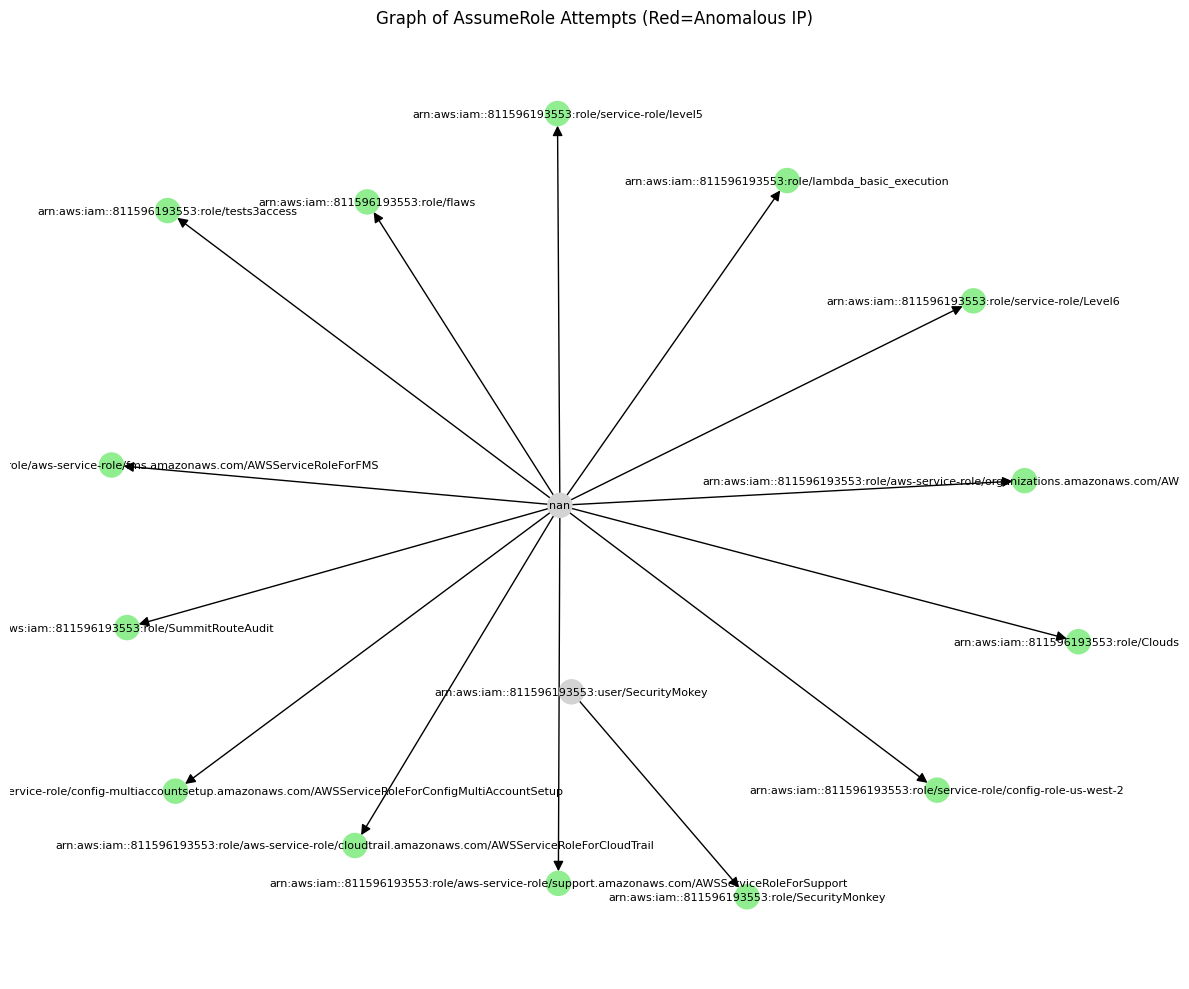

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume 'G_identity' is your identity graph object loaded in memory.
# Assume 'anomaly_nodes' list (strings of anomalous IPs) is also available.

print("--- Analyzing AssumeRole Interactions ---")

assume_role_edges = []
anomalous_assume_role_attempts = 0

# Iterate through all edges in the identity graph
for u, v, data in G_identity.edges(data=True):
    event = data.get('event', 'Unknown')
    # Check if the event associated with the edge is 'AssumeRole'
    if event == 'AssumeRole':
        principal_node = u # The source of the AssumeRole attempt
        target_role = v    # The Role ARN being targeted
        
        # Check if the principal is an anomalous IP
        is_anomalous = False
        if G_identity.nodes[principal_node].get('type') == 'IP' and principal_node in anomaly_nodes:
            is_anomalous = True
            anomalous_assume_role_attempts += 1
            
        assume_role_edges.append({
            'Principal': principal_node,
            'Principal Type': G_identity.nodes[principal_node].get('type'),
            'Target Role': target_role,
            'Anomalous Principal?': is_anomalous
        })

# Display the findings
if assume_role_edges:
    df_assume_role = pd.DataFrame(assume_role_edges)
    print(f"Found {len(df_assume_role)} 'AssumeRole' attempts:")
    # Display the table, maybe adjust display options if needed
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        print(df_assume_role)
    print(f"\nNumber of 'AssumeRole' attempts initiated by anomalous IPs: {anomalous_assume_role_attempts}")
else:
    print("No 'AssumeRole' edges were found in the graph.")

# --- Optional: Visualize this sparse graph ---
if assume_role_edges:
    print("\nGenerating visualization of AssumeRole attempts...")
    plt.figure(figsize=(12, 10))
    
    # Create a subgraph containing only the nodes involved in AssumeRole
    nodes_involved = set(df_assume_role['Principal']) | set(df_assume_role['Target Role'])
    subgraph_assume = G_identity.subgraph(nodes_involved)
    
    pos = nx.spring_layout(subgraph_assume, k=0.5, seed=42) # Adjust layout spacing
    
    # Define colors based on node type and anomaly status
    node_colors = []
    for node in subgraph_assume.nodes():
        node_data = G_identity.nodes[node]
        if node_data.get('type') == 'IP':
            if node_data.get('anomaly') == 'Anomaly':
                node_colors.append('red')
            else:
                node_colors.append('skyblue')
        elif node_data.get('type') == 'ARN':
             node_colors.append('lightgray') # Regular ARN principals
        elif node_data.get('type') == 'RoleARN':
             node_colors.append('lightgreen') # Target roles
        else:
             node_colors.append('gray')

    nx.draw_networkx_nodes(subgraph_assume, pos, node_color=node_colors, node_size=300)
    nx.draw_networkx_edges(subgraph_assume, pos, edge_color='black', arrows=True, arrowsize=15)
    nx.draw_networkx_labels(subgraph_assume, pos, font_size=8)
    
    plt.title("Graph of AssumeRole Attempts (Red=Anomalous IP)")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("assume_role_graph.png")
    print("Visualization saved to assume_role_graph.png")

In [15]:
import pandas as pd
import networkx as nx
from datetime import timedelta
import numpy as np # Import numpy to check for np.nan

# Assume 'G_identity', 'G_temporal', 'df_assume_role', and 'anomaly_nodes' are loaded/available.

print("--- Analyzing ARN Principals Performing AssumeRole ---")

arn_principals_assuming_role = []
target_arn_to_trace = None # Initialize target ARN

if 'df_assume_role' in locals() and not df_assume_role.empty:
    # Filter for principals that are ARNs
    arn_principals_df = df_assume_role[df_assume_role['Principal Type'] == 'ARN'].copy()

    # --- FINAL ROBUST FIX: Explicitly filter out None, np.nan, empty strings, AND the string "nan" ---
    def is_valid_principal_arn(p):
        if p is None or p is np.nan:
            return False
        if isinstance(p, str):
            p_stripped = p.strip()
            # Check if it's not empty, not literally "nan", and looks like an ARN
            return p_stripped != '' and p_stripped.lower() != 'nan' and p_stripped.startswith('arn:aws:')
        return False # Not a string

    arn_principals_df = arn_principals_df[
        arn_principals_df['Principal'].apply(is_valid_principal_arn)
    ]

    arn_principals_assuming_role = arn_principals_df['Principal'].unique().tolist()

    if arn_principals_assuming_role:
        print(f"Found {len(arn_principals_assuming_role)} unique, valid ARN principals performing AssumeRole.")
        # --- Trace Back Activity for the First VALID ARN Found ---
        target_arn_to_trace = arn_principals_assuming_role[0] # Select the first valid ARN

        # --- Safety Check: Ensure the target exists in the graphs ---
        if not G_identity.has_node(target_arn_to_trace) or not G_temporal.has_node(target_arn_to_trace):
             print(f"Error: Selected ARN principal '{target_arn_to_trace}' does not exist as a node in the graphs. Cannot trace.")
        else:
            print(f"\nTracing activity leading up to AssumeRole for ARN: {target_arn_to_trace}")

            # Find the timestamp(s) when this ARN performed AssumeRole
            assume_role_timestamps = []
            for u, v, data in G_identity.out_edges(target_arn_to_trace, data=True):
                 if data.get('event') == 'AssumeRole':
                     if G_temporal.has_edge(target_arn_to_trace, v):
                          edge_data_temp = G_temporal.get_edge_data(target_arn_to_trace, v)
                          if edge_data_temp and edge_data_temp.get('event') == 'AssumeRole':
                               ts = edge_data_temp.get('timestamp')
                               if ts: assume_role_timestamps.append(ts)

            if assume_role_timestamps:
                earliest_assume_role_time = min(assume_role_timestamps)
                print(f"Earliest AssumeRole time found for this ARN: {earliest_assume_role_time}")
                start_time = earliest_assume_role_time - timedelta(hours=24)
                end_time = earliest_assume_role_time

                print(f"\nLooking for events involving ARN '{target_arn_to_trace}' between {start_time} and {end_time}...")
                preceding_events_arn = []
                for u, v, data in G_temporal.in_edges(target_arn_to_trace, data=True):
                     ts = data.get('timestamp')
                     if ts and start_time <= ts < end_time:
                         is_anomalous_source = (G_temporal.nodes.get(u, {}).get('type') == 'IP' and u in anomaly_nodes)
                         preceding_events_arn.append({
                             'Timestamp': ts,
                             'Event': data.get('event'),
                             'Source': u,
                             'Source Type': G_temporal.nodes.get(u, {}).get('type'),
                             'Source Anomalous?': is_anomalous_source
                         })

                if preceding_events_arn:
                    sorted_preceding_arn = sorted(preceding_events_arn, key=lambda x: x['Timestamp'])
                    print(f"\nFound {len(sorted_preceding_arn)} preceding incoming events for '{target_arn_to_trace}':")
                    found_anomaly_link = False
                    for event_data in sorted_preceding_arn:
                         ts_str = event_data['Timestamp'].strftime('%Y-%m-%d %H:%M:%S %Z')
                         anomaly_marker = "*" if event_data['Source Anomalous?'] else ""
                         print(f"  {anomaly_marker}- [{ts_str}] Event: '{event_data['Event']}' <-- Source: {event_data['Source']} (Type: {event_data['Source Type']})")
                         if event_data['Source Anomalous?']: found_anomaly_link = True
                    if found_anomaly_link:
                         print("\n*** Found preceding activity originating from an Anomalous IP! ***")
                    else:
                         print("\nNo direct preceding activity from Anomalous IPs found in this timeframe.")
                else:
                     print(f"\nNo preceding incoming events found for '{target_arn_to_trace}' in this timeframe.")
            else:
                 print(f"Could not find timestamp for AssumeRole events initiated by {target_arn_to_trace}.")
    else:
        print("No valid ARN principals found performing AssumeRole after filtering invalid entries.")
else:
    print("Could not find df_assume_role DataFrame. Please run the AssumeRole analysis step first.")

--- Analyzing ARN Principals Performing AssumeRole ---
Found 1 unique, valid ARN principals performing AssumeRole.

Tracing activity leading up to AssumeRole for ARN: arn:aws:iam::811596193553:user/SecurityMokey
Could not find timestamp for AssumeRole events initiated by arn:aws:iam::811596193553:user/SecurityMokey.


In [16]:
import pandas as pd
import networkx as nx
from datetime import timedelta

# Assume 'G_identity', 'G_temporal', 'df_assume_role', and 'anomaly_nodes' are loaded/available.

print("--- Analyzing ARN Principals Performing AssumeRole ---")

arn_principals_assuming_role = []
target_arn_to_trace = None # Initialize target ARN

if 'df_assume_role' in locals() and not df_assume_role.empty:
    # Filter for principals that are ARNs (not IPs)
    arn_principals_df = df_assume_role[df_assume_role['Principal Type'] == 'ARN'].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    # --- THIS IS THE FIX ---
    # Filter out any NaN values from the Principal column before getting unique values
    arn_principals_df.dropna(subset=['Principal'], inplace=True)
    arn_principals_assuming_role = arn_principals_df['Principal'].unique().tolist()

    if arn_principals_assuming_role:
        print(f"Found {len(arn_principals_assuming_role)} unique, valid ARN principals performing AssumeRole.")
        # --- Trace Back Activity for the First VALID ARN Found ---
        target_arn_to_trace = arn_principals_assuming_role[0] # Select the first valid ARN
        print(f"\nTracing activity leading up to AssumeRole for ARN: {target_arn_to_trace}")

        # Find the timestamp(s) when this ARN performed AssumeRole
        assume_role_timestamps = []
        # Ensure target_arn_to_trace is a valid node before proceeding
        if G_identity.has_node(target_arn_to_trace):
            for u, v, data in G_identity.out_edges(target_arn_to_trace, data=True):
                 if data.get('event') == 'AssumeRole':
                     # Find corresponding edge in G_temporal to get timestamp
                     if G_temporal.has_edge(target_arn_to_trace, v):
                          edge_data_temp = G_temporal.get_edge_data(target_arn_to_trace, v)
                          if edge_data_temp and edge_data_temp.get('event') == 'AssumeRole':
                               ts = edge_data_temp.get('timestamp')
                               if ts: assume_role_timestamps.append(ts)

            if assume_role_timestamps:
                # Use the earliest AssumeRole time found for tracing back
                earliest_assume_role_time = min(assume_role_timestamps)
                print(f"Earliest AssumeRole time found for this ARN: {earliest_assume_role_time}")
                start_time = earliest_assume_role_time - timedelta(hours=24) # Look back 24 hours
                end_time = earliest_assume_role_time

                print(f"\nLooking for events involving ARN '{target_arn_to_trace}' between {start_time} and {end_time}...")
                preceding_events_arn = []
                # Check incoming edges TO the ARN within the time window
                for u, v, data in G_temporal.in_edges(target_arn_to_trace, data=True):
                     ts = data.get('timestamp')
                     if ts and start_time <= ts < end_time:
                         is_anomalous_source = (G_temporal.nodes.get(u, {}).get('type') == 'IP' and u in anomaly_nodes)
                         preceding_events_arn.append({
                             'Timestamp': ts,
                             'Event': data.get('event'),
                             'Source': u,
                             'Source Type': G_temporal.nodes.get(u, {}).get('type'),
                             'Source Anomalous?': is_anomalous_source
                         })

                # Sort and display
                if preceding_events_arn:
                    sorted_preceding_arn = sorted(preceding_events_arn, key=lambda x: x['Timestamp'])
                    print(f"\nFound {len(sorted_preceding_arn)} preceding incoming events for '{target_arn_to_trace}':")
                    found_anomaly_link = False
                    for event_data in sorted_preceding_arn:
                         ts_str = event_data['Timestamp'].strftime('%Y-%m-%d %H:%M:%S %Z')
                         anomaly_marker = "*" if event_data['Source Anomalous?'] else ""
                         print(f"  {anomaly_marker}- [{ts_str}] Event: '{event_data['Event']}' <-- Source: {event_data['Source']} (Type: {event_data['Source Type']})")
                         if event_data['Source Anomalous?']: found_anomaly_link = True
                    if found_anomaly_link:
                         print("\n*** Found preceding activity originating from an Anomalous IP! ***")
                    else:
                         print("\nNo direct preceding activity from Anomalous IPs found in this timeframe.")
                else:
                     print(f"\nNo preceding incoming events found for '{target_arn_to_trace}' in this timeframe.")
            else:
                 print(f"Could not find timestamp for AssumeRole events initiated by {target_arn_to_trace}.")
        else:
             print(f"ARN node {target_arn_to_trace} not found in G_identity graph.") # Added check
    else:
        print("No valid ARN principals found performing AssumeRole after filtering NaNs.")
else:
    print("Could not find df_assume_role DataFrame. Please run the previous analysis step first.")

--- Analyzing ARN Principals Performing AssumeRole ---
Found 2 unique, valid ARN principals performing AssumeRole.

Tracing activity leading up to AssumeRole for ARN: nan
Could not find timestamp for AssumeRole events initiated by nan.



--- Analyzing Widespread ListBuckets Reconnaissance ---
Found 95 'ListBuckets' events originating from 87 anomalous IPs.
These events targeted 4 unique ARNs.
Targets:
  - arn:aws:iam::811596193553:user/Level6
  - arn:aws:iam::811596193553:user/backup
  - arn:aws:sts::811596193553:assumed-role/aws:ec2-instance/i-aa2d3b42e5c6e801a
  - arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a

Generating visualization of 'ListBuckets' reconnaissance...
Visualization saved to listbuckets_recon_graph.png


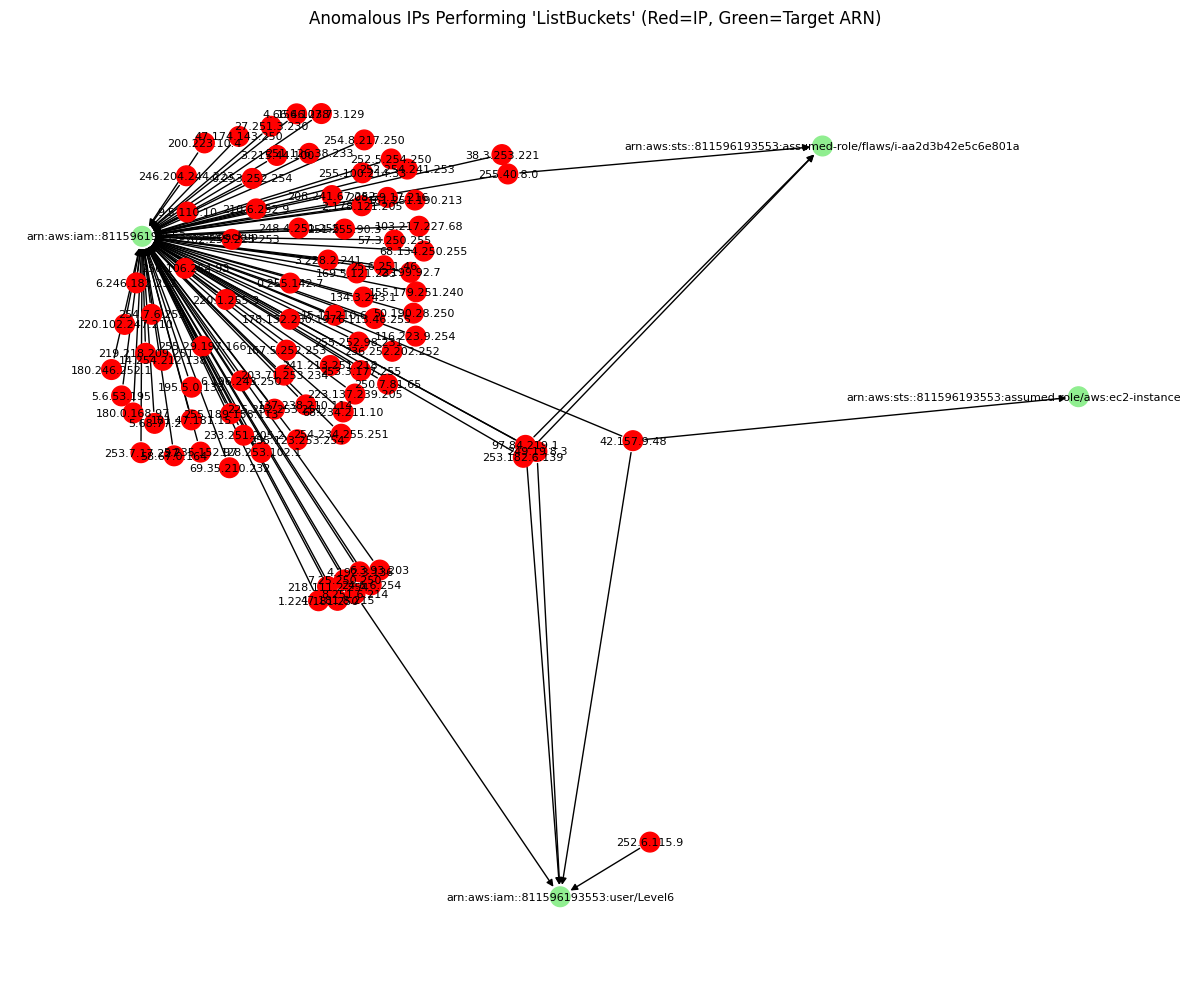

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume 'G_full' and 'anomaly_nodes' are available.

print("\n--- Analyzing Widespread ListBuckets Reconnaissance ---")

listbuckets_edges = []
listbuckets_targets = set()
listbuckets_anomalous_sources = set()

# Iterate through edges originating from anomalous IPs
for source_ip in anomaly_nodes:
    if source_ip in G_full: # Check if node exists in graph
        for u, v, data in G_full.out_edges(source_ip, data=True):
            if data.get('event') == 'ListBuckets':
                listbuckets_edges.append((u, v))
                listbuckets_targets.add(v) # Collect unique targets
                listbuckets_anomalous_sources.add(u) # Collect unique anomalous sources

print(f"Found {len(listbuckets_edges)} 'ListBuckets' events originating from {len(listbuckets_anomalous_sources)} anomalous IPs.")
print(f"These events targeted {len(listbuckets_targets)} unique ARNs.")
if listbuckets_targets:
    print("Targets:")
    for target in sorted(list(listbuckets_targets))[:10]: # Show first 10 targets
        print(f"  - {target}")
    if len(listbuckets_targets) > 10: print("  ...")


# --- Visualize the ListBuckets Subgraph ---
if listbuckets_edges:
    print("\nGenerating visualization of 'ListBuckets' reconnaissance...")
    plt.figure(figsize=(12, 10))

    # Create subgraph with only relevant nodes and edges
    nodes_in_subgraph = listbuckets_anomalous_sources | listbuckets_targets
    subgraph_listbuckets = G_full.subgraph(nodes_in_subgraph)

    pos = nx.spring_layout(subgraph_listbuckets, k=0.3, seed=42)

    # Define colors
    node_colors = []
    for node in subgraph_listbuckets.nodes():
        node_data = G_full.nodes[node] # Get data from original graph
        if node_data.get('type') == 'IP': # Should all be anomalous IPs
            node_colors.append('red')
        elif node_data.get('type') == 'ARN':
             node_colors.append('lightgreen') # Targets
        else:
             node_colors.append('gray')

    nx.draw_networkx_nodes(subgraph_listbuckets, pos, node_color=node_colors, node_size=200)
    # Draw only the ListBuckets edges
    specific_edges = [edge for edge in subgraph_listbuckets.edges() if G_full.edges[edge].get('event') == 'ListBuckets']
    nx.draw_networkx_edges(subgraph_listbuckets, pos, edgelist=specific_edges, edge_color='black', arrows=True, arrowsize=10)
    nx.draw_networkx_labels(subgraph_listbuckets, pos, font_size=8)

    plt.title("Anomalous IPs Performing 'ListBuckets' (Red=IP, Green=Target ARN)")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("listbuckets_recon_graph.png")
    print("Visualization saved to listbuckets_recon_graph.png")

In [18]:
import networkx as nx

# Assume 'G_full' is your full graph object already loaded in memory.
# If not, you would need to re-run the script that builds G_full first.

graphml_file = 'full_graph.graphml'

print(f"Attempting to export the graph G_full ({G_full.number_of_nodes()} nodes, {G_full.number_of_edges()} edges)...")

try:
    # Export the graph to GraphML format
    nx.write_graphml(G_full, graphml_file)
    print(f"\nGraph successfully exported to '{graphml_file}'")
    print("\nYou can now open this file in graph visualization software like Gephi or Cytoscape.")
    print("In Gephi, you can:")
    print("  - Use layout algorithms (e.g., ForceAtlas2, Yifan Hu).")
    print("  - Color nodes based on the 'anomaly' attribute (red/blue).")
    print("  - Size nodes based on degree (number of connections).")
    print("  - Filter nodes/edges based on attributes.")

except NameError:
    print("\nError: The graph object 'G_full' was not found in memory.")
    print("Please re-run the code that builds the full graph first.")
except Exception as e:
    print(f"\nAn error occurred during export: {e}")

Attempting to export the graph G_full (9460 nodes, 11624 edges)...

Graph successfully exported to 'full_graph.graphml'

You can now open this file in graph visualization software like Gephi or Cytoscape.
In Gephi, you can:
  - Use layout algorithms (e.g., ForceAtlas2, Yifan Hu).
  - Color nodes based on the 'anomaly' attribute (red/blue).
  - Size nodes based on degree (number of connections).
  - Filter nodes/edges based on attributes.


In [19]:
import networkx as nx

# Assume 'G_temporal' is loaded in memory

print("--- Listing ARN Nodes in G_temporal ---")

arn_nodes_in_temporal = [n for n, d in G_temporal.nodes(data=True) if d.get('type') == 'ARN']

if arn_nodes_in_temporal:
    print(f"Found {len(arn_nodes_in_temporal)} ARN nodes:")
    # Print the list - look for 'SecurityMonkey' or similar
    for node_name in sorted(arn_nodes_in_temporal):
        if 'SecurityMo' in node_name: # Filter to likely candidates
            print(f"  - {node_name}")
else:
    print("No nodes with type 'ARN' were found in G_temporal.")
    

--- Listing ARN Nodes in G_temporal ---
Found 58 ARN nodes:
  - arn:aws:iam::811596193553:user/SecurityMokey
  - arn:aws:sts::811596193553:assumed-role/SecurityMonkey/cloudaux
  - arn:aws:sts::811596193553:assumed-role/SecurityMonkey/secmonkey


In [20]:
import pandas as pd
import networkx as nx
from datetime import timedelta
import numpy as np # Import numpy to check for np.nan

# Assume 'G_temporal' graph is loaded.
# Assume 'anomaly_nodes' list (strings of anomalous IPs) is available.
# Assume 'G_identity' graph is loaded (to confirm target is RoleARN).

print("--- Tracing Activity Preceding AssumeRole by ARN (Corrected ARN) ---")

# --- Use the Correctly Identified Target ARN ---
target_arn = "arn:aws:iam::811596193553:user/SecurityMokey" # Corrected based on inspection

if not G_temporal.has_node(target_arn):
    print(f"Error: Target ARN '{target_arn}' still not found in G_temporal. Check graph building steps.")
else:
    print(f"Analyzing preceding activity for ARN: {target_arn}")

    # --- Find Earliest AssumeRole Timestamp for this ARN ---
    assume_role_timestamps = []
    # Check outgoing edges from this ARN in G_temporal
    for u, v, data in G_temporal.out_edges(target_arn, data=True):
        # Check if the target is a RoleARN (using G_identity for type) and event is AssumeRole
        # Ensure target node v exists in G_identity before checking its type
        if G_identity.has_node(v) and G_identity.nodes[v].get('type') == 'RoleARN' and data.get('event') == 'AssumeRole':
            ts = data.get('timestamp')
            if ts:
                assume_role_timestamps.append(ts)

    if assume_role_timestamps:
        earliest_assume_role_time = min(assume_role_timestamps)
        print(f"Earliest AssumeRole time found for this ARN: {earliest_assume_role_time}")

        # --- Search for Preceding Activity from Anomalous IPs ---
        start_time = earliest_assume_role_time - timedelta(days=7) # Look back 7 days
        end_time = earliest_assume_role_time

        print(f"\nLooking for incoming events from Anomalous IPs to '{target_arn}' between {start_time} and {end_time}...")

        preceding_anomalous_events = []
        # Check incoming edges TO the target_arn
        for source_node, target_node, data in G_temporal.in_edges(target_arn, data=True):
            ts = data.get('timestamp')
            # Check if timestamp is within the window AND source is an anomalous IP
            if ts and start_time <= ts < end_time and source_node in anomaly_nodes:
                preceding_anomalous_events.append({
                    'Timestamp': ts,
                    'Event': data.get('event'),
                    'Source IP': source_node,
                })

        # --- Display Findings ---
        if preceding_anomalous_events:
            sorted_preceding = sorted(preceding_anomalous_events, key=lambda x: x['Timestamp'])
            print(f"\n*** Found {len(sorted_preceding)} preceding events from Anomalous IPs linked to '{target_arn}': ***")
            for event_data in sorted_preceding:
                 ts_str = event_data['Timestamp'].strftime('%Y-%m-%d %H:%M:%S %Z')
                 print(f"  - [{ts_str}] Event: '{event_data['Event']}' <-- Source Anomaly IP: {event_data['Source IP']}")
            print("\nThis suggests a potential link between initial anomalous reconnaissance and later privilege escalation.")
        else:
            print(f"\nNo direct preceding events found from Anomalous IPs targeting '{target_arn}' within the {timedelta(days=7).days}-day window before the AssumeRole attempt.")

    else:
        print(f"Could not find any AssumeRole events initiated by '{target_arn}' with timestamps in G_temporal.")

--- Tracing Activity Preceding AssumeRole by ARN (Corrected ARN) ---
Analyzing preceding activity for ARN: arn:aws:iam::811596193553:user/SecurityMokey
Could not find any AssumeRole events initiated by 'arn:aws:iam::811596193553:user/SecurityMokey' with timestamps in G_temporal.


In [21]:
import pandas as pd
import networkx as nx
from datetime import timedelta
import numpy as np

# Assume 'G_identity', 'G_temporal', and 'anomaly_nodes' are loaded/available.

print("--- Analyzing AssumeRole Events Directly from Graphs ---")

# --- Step 1: Find AssumeRole events in G_identity ---
assume_role_principals = {} # Store {principal: earliest_timestamp}
valid_arn_principals = [] # Store valid ARNs found

for u, v, data in G_identity.edges(data=True):
    if data.get('event') == 'AssumeRole':
        principal = u
        target_role = v
        principal_type = G_identity.nodes[u].get('type')

        # Find the corresponding timestamp in G_temporal
        timestamp = None
        if G_temporal.has_edge(principal, target_role):
            edge_data_temp = G_temporal.get_edge_data(principal, target_role)
            # Ensure the edge in G_temporal is also an AssumeRole before taking timestamp
            if edge_data_temp and edge_data_temp.get('event') == 'AssumeRole':
                 timestamp = edge_data_temp.get('timestamp')

        # Store the earliest timestamp found for this principal
        if timestamp:
            if principal not in assume_role_principals or timestamp < assume_role_principals[principal]:
                assume_role_principals[principal] = timestamp

            # Check if it's a valid ARN principal (string, starts with arn:aws:)
            if principal_type == 'ARN' and isinstance(principal, str) and principal.startswith('arn:aws:'):
                 if principal not in valid_arn_principals:
                      valid_arn_principals.append(principal)

# --- Step 2: Select a Valid ARN Principal and Trace Back ---
target_arn_to_trace = None
if valid_arn_principals:
    # Sort ARNs alphabetically to get a consistent one if multiple exist
    target_arn_to_trace = sorted(valid_arn_principals)[0]
    print(f"\nFound {len(valid_arn_principals)} valid ARN principals performing AssumeRole.")
    print(f"Selected ARN for traceback: {target_arn_to_trace}")

    earliest_assume_role_time = assume_role_principals.get(target_arn_to_trace)

    if earliest_assume_role_time:
        print(f"Earliest AssumeRole time found for this ARN: {earliest_assume_role_time}")
        start_time = earliest_assume_role_time - timedelta(days=7) # Look back 7 days
        end_time = earliest_assume_role_time

        print(f"\nLooking for incoming events from Anomalous IPs to '{target_arn_to_trace}' between {start_time} and {end_time}...")
        preceding_anomalous_events = []
        # Check incoming edges TO the target_arn in G_temporal
        for source_node, target_node, data in G_temporal.in_edges(target_arn_to_trace, data=True):
             ts = data.get('timestamp')
             # Check if timestamp is within the window AND source is an anomalous IP
             if ts and start_time <= ts < end_time and source_node in anomaly_nodes:
                 preceding_anomalous_events.append({
                     'Timestamp': ts,
                     'Event': data.get('event'),
                     'Source IP': source_node,
                 })

        # --- Display Findings ---
        if preceding_anomalous_events:
            sorted_preceding = sorted(preceding_anomalous_events, key=lambda x: x['Timestamp'])
            print(f"\n*** Found {len(sorted_preceding)} preceding events from Anomalous IPs linked to '{target_arn_to_trace}': ***")
            for event_data in sorted_preceding:
                 ts_str = event_data['Timestamp'].strftime('%Y-m-%d %H:%M:%S %Z')
                 print(f"  - [{ts_str}] Event: '{event_data['Event']}' <-- Source Anomaly IP: {event_data['Source IP']}")
            print("\nThis suggests a potential link between initial anomalous reconnaissance and later privilege escalation.")
        else:
            print(f"\nNo direct preceding events found from Anomalous IPs targeting '{target_arn_to_trace}' within the {timedelta(days=7).days}-day window before the AssumeRole attempt.")
    else:
        print(f"Could not confirm timestamp for AssumeRole events initiated by {target_arn_to_trace} in G_temporal edges.")
else:
    print("\nNo valid ARN principals performing AssumeRole with timestamps found in the graphs.")

--- Analyzing AssumeRole Events Directly from Graphs ---

No valid ARN principals performing AssumeRole with timestamps found in the graphs.


In [22]:
import pandas as pd
import networkx as nx
from collections import Counter

# Assume 'G_full' is your full graph object already loaded in memory.
# Assume 'anomaly_nodes' list (strings of anomalous IPs) is also available.

print("--- Deeper Analysis of 'ListBuckets' Reconnaissance ---")

# --- Step 1: Filter relevant edges ---
listbuckets_edges = []
targets_per_ip = Counter() # {ip: set(target_arns)}
sources_per_target = Counter() # {target_arn: set(source_ips)}

# Iterate through edges originating from anomalous IPs
for source_ip in anomaly_nodes:
    if source_ip in G_full: # Check if node exists in graph
        targets = set() # Store targets for this specific IP
        for u, v, data in G_full.out_edges(source_ip, data=True):
            if data.get('event') == 'ListBuckets':
                listbuckets_edges.append((u, v))
                targets.add(v) # Add target ARN to the set for this IP
                # Add source IP to the set for this target ARN
                if v not in sources_per_target:
                    sources_per_target[v] = set()
                sources_per_target[v].add(u)
        # Store the unique targets found for this IP
        if targets:
            targets_per_ip[source_ip] = targets

# --- Step 2: Analyze IPs targeting the most ARNs ---
print(f"\nAnalysis based on {len(listbuckets_edges)} 'ListBuckets' events from {len(targets_per_ip)} anomalous IPs.")

# Count unique targets per IP
ip_target_counts = {ip: len(target_set) for ip, target_set in targets_per_ip.items()}
# Sort IPs by the number of unique targets, descending
sorted_ips_by_targets = sorted(ip_target_counts.items(), key=lambda item: item[1], reverse=True)

print("\n--- Top 5 Anomalous IPs by Number of Unique ARNs Targeted with 'ListBuckets' ---")
for ip, count in sorted_ips_by_targets[:5]:
    print(f"  - IP: {ip}, Targets: {count}")
    # Optionally list the specific targets:
    # print(f"    Targets: {', '.join(sorted(list(targets_per_ip[ip])))}")

# --- Step 3: Analyze ARNs targeted by the most IPs ---
# Count unique anomalous source IPs per target ARN
target_source_counts = {target: len(source_set) for target, source_set in sources_per_target.items()}
# Sort Targets by the number of unique anomalous sources, descending
sorted_targets_by_sources = sorted(target_source_counts.items(), key=lambda item: item[1], reverse=True)

print("\n--- Top ARNs Targeted by the Most Unique Anomalous IPs via 'ListBuckets' ---")
for target, count in sorted_targets_by_sources[:5]: # Show top 5 targets
    print(f"  - Target ARN: {target}, Targeted by: {count} unique anomalous IPs")

--- Deeper Analysis of 'ListBuckets' Reconnaissance ---

Analysis based on 95 'ListBuckets' events from 87 anomalous IPs.

--- Top 5 Anomalous IPs by Number of Unique ARNs Targeted with 'ListBuckets' ---
  - IP: 97.84.219.1, Targets: 3
  - IP: 42.157.9.48, Targets: 3
  - IP: 255.40.8.0, Targets: 2
  - IP: 253.182.6.139, Targets: 2
  - IP: 8.251.6.214, Targets: 2

--- Top ARNs Targeted by the Most Unique Anomalous IPs via 'ListBuckets' ---
  - Target ARN: arn:aws:iam::811596193553:user/backup, Targeted by: 86 unique anomalous IPs
  - Target ARN: arn:aws:iam::811596193553:user/Level6, Targeted by: 5 unique anomalous IPs
  - Target ARN: arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a, Targeted by: 3 unique anomalous IPs
  - Target ARN: arn:aws:sts::811596193553:assumed-role/aws:ec2-instance/i-aa2d3b42e5c6e801a, Targeted by: 1 unique anomalous IPs
